#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor 
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

In [3]:
data.head() #посмотрим первые строки

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info() #посмотрим тип данных и количество строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Количество строк одинаковое, пропуски отсутствуют

In [5]:
data = data.set_index('datetime')

In [6]:
data.sort_index(inplace=True) #посмотрим на хронологию

In [7]:
data.index.is_monotonic

True

In [8]:
data = data.resample('1H').sum() #ресемплируем данные по одному часу

In [9]:
data.head() #проверим

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
data.index.year.value_counts()

2018    4416
Name: datetime, dtype: int64

<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px">
Наши данные за 2018 год, пропуски отсутствуют, установлен индекс таблицы равным столбцу даты и времени, выполнена замена интервала временного ряда.

## Анализ

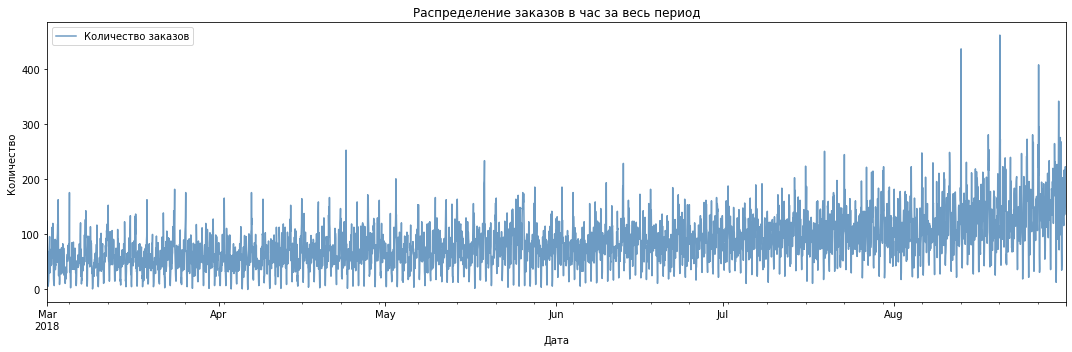

In [11]:
data.plot(ax=plt.gca(),figsize=(15,5), color='#6d9bc3', )
plt.legend(['Количество заказов'])
plt.title('Распределение заказов в час за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

Среднее количество заказов расчет, особенно в летний период, преимущественно в августе.  Посмотрим тренды и сезонность.

**Тренды и сезонность**

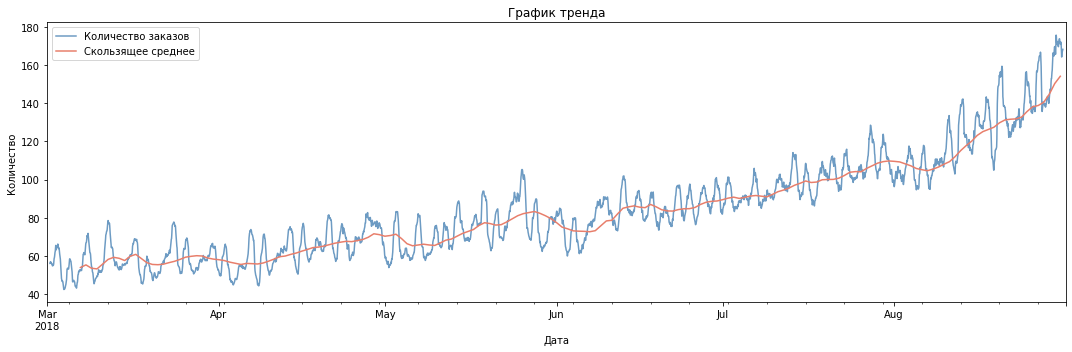

In [12]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(ax=plt.gca(), figsize=(12,4), color='#6d9bc3')
decomposed.trend.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca(),figsize=(15,5), color='#e87e6b')
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.title('График тренда')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()



Заметно явное увеличение заказов такси с июня по июль, существенный рост в августе - пора отпусков.

Посмотрим сезонность в будний и выходные дни, за неделю в августе

In [13]:
def plot_time(data, title, xlabel, ylabel):
    data.plot(grid=True, legend=False, figsize=(13, 4), title=title, color='#6d9bc3').set(xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

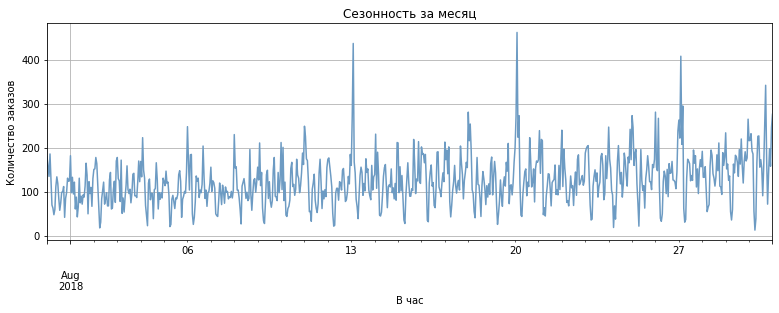

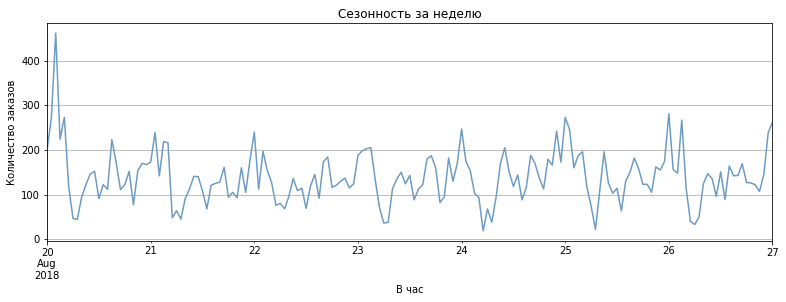

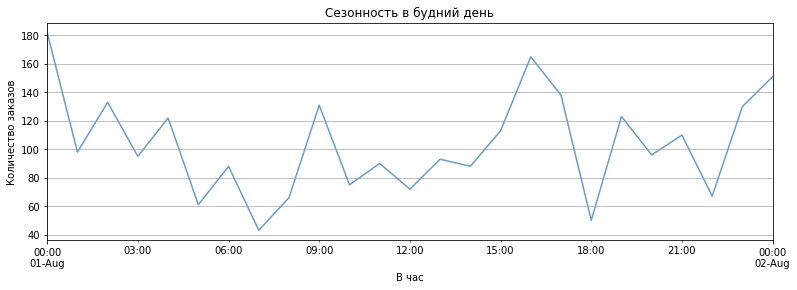

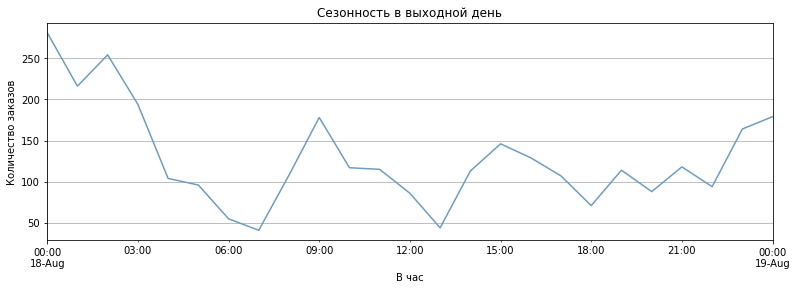

In [14]:
plot_time(
    data['2018-07-31 00:00:00':'2018-08-31 00:00:00'], 
    'Сезонность за месяц', 
    'В час', 
    'Количество заказов',
)    
plot_time(
    data['2018-08-20 00:00:00':'2018-08-27 00:00:00'], 
    'Сезонность за неделю', 
    'В час', 
    'Количество заказов',
)
plot_time(
    data['2018-08-01 00:00:00':'2018-08-02 00:00:00'], 
    'Сезонность в будний день', 
    'В час', 
    'Количество заказов',
)
plot_time(
    data['2018-08-18 00:00:00':'2018-08-19 00:00:00'], 
    'Сезонность в выходной день', 
    'В час', 
    'Количество заказов',
)

<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px"> 
Рассмотрев сезонность августа, видим пики заказов в воскресенье, возможно, из-за прилетов ночных рейсов.<br/>
В будние дни видим пики заказов в утренние часы, во второй половине дня и после 18:00.<br/>
В выходные дни в ночное время больше заказов, также видим пик заказов в ночь на понедельник.

## Обучение

### Подготовка данных

Добавим новые признаки, разделим данные на тренировочную и тестовую выборки

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    taxi = data.copy()
    taxi['month'] = taxi.index.month
    taxi['day'] = taxi.index.day
    taxi['day_of_week'] = taxi.index.dayofweek.astype('category')
    
    taxi.loc[(taxi.index.hour >= 0) & (taxi.index.hour < 6), 'time_of_day'] = 'night'
    taxi.loc[(taxi.index.hour >= 6) & (taxi.index.hour < 12), 'time_of_day'] = 'morning'
    taxi.loc[(taxi.index.hour >= 12) & (taxi.index.hour < 18), 'time_of_day'] = 'day'
    taxi.loc[(taxi.index.hour >= 18) & (taxi.index.hour < 24), 'time_of_day'] = 'evening'
    taxi['time_of_day'] = taxi['time_of_day'].astype('category') #признаки календарные и времени дня
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
        taxi['lag_week'] = taxi['num_orders'].shift(24 * 7) #сдвиги
    
    taxi['rolling_mean_{}'.format(rolling_mean_size)] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()
    return taxi #скользящее среднее

In [16]:
taxi = make_features(data, 24, 24)
taxi.dropna(inplace=True)

In [17]:
state = np.random.RandomState(12345) #зафиксируем random_state

In [18]:
features = taxi.drop(['num_orders'], axis=1)
target = taxi['num_orders'] #признаки и целевой признак

In [19]:
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                            target,
                                                                            shuffle=False,
                                                                            test_size = 0.2,
                                                                            random_state=state)

In [20]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size = 0.5,
                                                                            shuffle=False,
                                                                            random_state=state)

In [21]:
features_train.shape, features_valid.shape, features_test.shape #посмотрим размеры выборок

((3398, 30), (425, 30), (425, 30))

In [22]:
cat = ['day_of_week', 'time_of_day'] #категориальные признаки

In [23]:
ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(features_train[cat])

def features_ohe(ohe_variable, taxi_features, cat):
    taxi_features_ohe = pd.DataFrame(data=ohe_variable.transform(taxi_features[cat]),
                                     index=taxi_features.index, columns=ohe_variable.get_feature_names())

    taxi_features = taxi_features.drop(cat, axis=1)
    taxi_features = taxi_features.join(taxi_features_ohe)
    return taxi_features

In [24]:
features_train_ohe = features_ohe(ohe, features_train, cat)
features_valid_ohe = features_ohe(ohe, features_valid, cat)
features_test_ohe = features_ohe(ohe, features_test, cat)

----

Напишем функции для времени обучения и предсказания, RMSE

In [25]:
def learning_time(model,features_train,target_train):
    start = time.time()
    model.fit(features_train,target_train)
    end = time.time()
    time_fit = end - start
    return time_fit,model #время обучения

In [26]:
def predicted_time(model,features_valid):
    start = time.time()
    predict = model.predict(features_valid)
    end = time.time()
    time_predict= end - start
    return time_predict,predict #время предсказания

In [27]:
results = pd.DataFrame(columns=['Время обучения', 'Время предсказания', 'RMSE', 'Модель']) 
#результаты работы моделей

In [28]:
def table_results(learn_time, pred_time, rmse, model, df):
    df.loc[model,'Время обучения'] = learn_time
    df.loc[model,'Время предсказания'] = pred_time
    df.loc[model,'RMSE'] = rmse
    df.loc[model,'Модель'] = model
    return df

### Модели

Обучим разные модели, попробуем разные гиперпараметры

**LightGBM Regressor**

*LightGBM - 1*

In [29]:
lgbm1_learn_time,lgbm1 = learning_time(LGBMRegressor(learning_rate=0.1, num_leaves=90, 
                                                     n_estimators=110,random_state=state),
                                       features_train, target_train)
lgbm1_pred_time,lgbm1_predict = predicted_time(lgbm1,features_valid)
lgbm1_rmse = np.sqrt(mean_squared_error(target_valid, lgbm1_predict))
table_results(lgbm1_learn_time,lgbm1_pred_time, lgbm1_rmse, 'LightGBM - 1',results)

,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,3.909118,0.007384,30.379066,LightGBM - 1


*LightGBM - 2*

In [30]:
lgbm2_learn_time,lgbm2 = learning_time(LGBMRegressor(learning_rate=0.1, num_leaves=190, 
                                                     n_estimators=130,random_state=state),
                                       features_train_ohe, target_train)
lgbm2_pred_time,lgbm2_predict = predicted_time(lgbm2,features_valid_ohe)
lgbm2_rmse = np.sqrt(mean_squared_error(target_valid, lgbm2_predict))
table_results(lgbm2_learn_time,lgbm2_pred_time, lgbm2_rmse, 'LightGBM - 2',results)

,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,3.909118,0.007384,30.379066,LightGBM - 1
LightGBM - 2,6.304222,0.003581,31.139973,LightGBM - 2


----

**Random Forest Regressor**

*Random Forest - 1*

In [31]:
rf1_learn_time,rf1 = learning_time(RandomForestRegressor(n_estimators=13, max_depth=15, random_state=state),
                                   features_train_ohe, target_train)
rf1_pred_time,rf1_predict = predicted_time(rf1,features_valid_ohe)
rf1_rmse = np.sqrt(mean_squared_error(target_valid, rf1_predict))
table_results(rf1_learn_time,rf1_pred_time, rf1_rmse, 'RandomForest - 1',results)

,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,3.909118,0.007384,30.379066,LightGBM - 1
LightGBM - 2,6.304222,0.003581,31.139973,LightGBM - 2
RandomForest - 1,0.678428,0.003796,32.915087,RandomForest - 1


*Random Forest - 2*

In [32]:
rf2_learn_time,rf2 = learning_time(RandomForestRegressor(n_estimators=25, max_depth=19, random_state=state),
                                   features_train_ohe, target_train)
rf2_pred_time,rf2_predict = predicted_time(rf2,features_valid_ohe)
rf2_rmse = np.sqrt(mean_squared_error(target_valid, rf2_predict))
table_results(rf2_learn_time,rf2_pred_time, rf2_rmse, 'RandomForest - 2',results)

,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,3.909118,0.007384,30.379066,LightGBM - 1
LightGBM - 2,6.304222,0.003581,31.139973,LightGBM - 2
RandomForest - 1,0.678428,0.003796,32.915087,RandomForest - 1
RandomForest - 2,1.217267,0.005189,31.283024,RandomForest - 2


----

**CatBoostRegressor**

*CatBoostRegressor - 1*

In [33]:
cat1_learn_time,cat1 = learning_time(CatBoostRegressor(loss_function = 'RMSE', learning_rate=0.01, 
                                                       iterations = 270, cat_features = cat, verbose=20), 
                                     features_train, target_train)
cat1_pred_time,cat1_predict = predicted_time(cat1,features_valid)
cat1_rmse = np.sqrt(mean_squared_error(target_valid, cat1_predict))
table_results(cat1_learn_time,cat1_pred_time, cat1_rmse, 'CatBoost - 1',results)

0:	learn: 35.6588009	total: 56.9ms	remaining: 15.3s
20:	learn: 32.2071472	total: 194ms	remaining: 2.3s
40:	learn: 29.4724739	total: 325ms	remaining: 1.81s
60:	learn: 27.3414040	total: 470ms	remaining: 1.61s
80:	learn: 25.6700710	total: 605ms	remaining: 1.41s
100:	learn: 24.3807894	total: 738ms	remaining: 1.24s
120:	learn: 23.4013517	total: 868ms	remaining: 1.07s
140:	learn: 22.6302571	total: 1000ms	remaining: 915ms
160:	learn: 22.0135560	total: 1.13s	remaining: 766ms
180:	learn: 21.5130412	total: 1.28s	remaining: 629ms
200:	learn: 21.1252165	total: 1.41s	remaining: 484ms
220:	learn: 20.8113932	total: 1.54s	remaining: 342ms
240:	learn: 20.5486283	total: 1.68s	remaining: 202ms
260:	learn: 20.3165410	total: 1.81s	remaining: 62.4ms
269:	learn: 20.2326396	total: 1.87s	remaining: 0us


,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,3.909118,0.007384,30.379066,LightGBM - 1
LightGBM - 2,6.304222,0.003581,31.139973,LightGBM - 2
RandomForest - 1,0.678428,0.003796,32.915087,RandomForest - 1
RandomForest - 2,1.217267,0.005189,31.283024,RandomForest - 2
CatBoost - 1,2.417268,0.002319,33.994316,CatBoost - 1


*CatBoostRegressor - 2*

In [34]:
cat2_learn_time,cat2 = learning_time(CatBoostRegressor(loss_function = 'RMSE', learning_rate=0.1, 
                                                       iterations = 110, cat_features = cat, verbose=13), 
                                     features_train, target_train)
cat2_pred_time,cat2_predict = predicted_time(cat2,features_valid)
cat2_rmse = np.sqrt(mean_squared_error(target_valid, cat2_predict))
table_results(cat2_learn_time,cat1_pred_time, cat2_rmse, 'CatBoost - 2',results)

0:	learn: 33.8712107	total: 6.34ms	remaining: 691ms
13:	learn: 22.5607642	total: 78.6ms	remaining: 539ms
26:	learn: 20.3274600	total: 150ms	remaining: 461ms
39:	learn: 19.4774550	total: 223ms	remaining: 390ms
52:	learn: 18.9301292	total: 307ms	remaining: 330ms
65:	learn: 18.4753034	total: 376ms	remaining: 251ms
78:	learn: 18.1097454	total: 446ms	remaining: 175ms
91:	learn: 17.8132226	total: 516ms	remaining: 101ms
104:	learn: 17.5171999	total: 585ms	remaining: 27.8ms
109:	learn: 17.3864489	total: 611ms	remaining: 0us


,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,3.909118,0.007384,30.379066,LightGBM - 1
LightGBM - 2,6.304222,0.003581,31.139973,LightGBM - 2
RandomForest - 1,0.678428,0.003796,32.915087,RandomForest - 1
RandomForest - 2,1.217267,0.005189,31.283024,RandomForest - 2
CatBoost - 1,2.417268,0.002319,33.994316,CatBoost - 1
CatBoost - 2,1.104857,0.002319,30.682992,CatBoost - 2


<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px"> 
Все модели прошли критерий значения метрики RMSE меньше 48.<br/>
Наилучший показатель RMSE 30.38 у модели LightGBM - 1, протестируем.

## Тестирование

In [35]:
model_lgbm = LGBMRegressor(learning_rate=0.1, num_leaves=90, n_estimators=110, random_state=state)
model_lgbm.fit(features_train_ohe, target_train)
predicted_lgbm = model_lgbm.predict(features_test_ohe)
print('Значение RMSE модели LightGBM-1 на тестовой выборке:', np.sqrt(mean_squared_error(target_test, predicted_lgbm)))

Значение RMSE модели LightGBM-1 на тестовой выборке: 44.04406617730845


Посмотрим на графике предсказанные значения лучшей модели и реальные тестовые

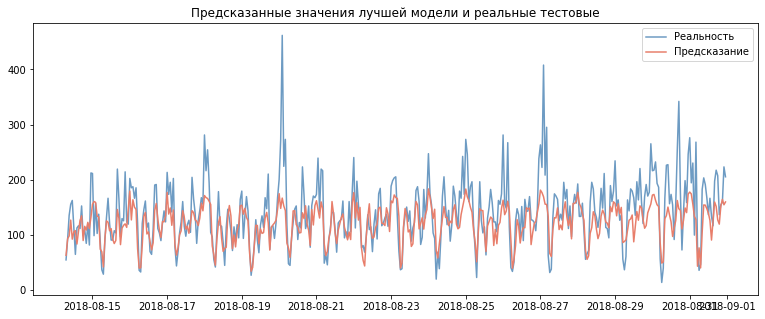

In [36]:
plt.figure(figsize=(13, 5))

plt.plot(target_test, label='Реальность', color='#6d9bc3')
plt.plot(target_test.index, predicted_lgbm, label='Предсказание', color='#e87e6b')

plt.title('Предсказанные значения лучшей модели и реальные тестовые')
plt.legend()
plt.show()

## Вывод

<div class="alert-info" style="padding: 20px; border-radius: 10px"> 
Наши данные за 2018 год, пропуски отсутствуют, установлен индекс таблицы равным столбцу даты и времени, выполнена замена интервала временного ряда. <br/>
Заметно явное увеличение заказов такси с июня по июль, существенный рост в августе - пора отпусков. Рассмотрев сезонность августа, видим пики заказов в воскресенье, возможно, из-за прилетов ночных рейсов.
В будние дни видим пики заказов в утренние часы, во второй половине дня и после 18:00.
В выходные дни в ночное время больше заказов, также видим пик заказов в ночь на понедельник. <br/>
    
Обучили модели с разными гиперпараметрами LightGBM Regressor, Random Forest Regressor и CatBoostRegressor. <br/>
Все модели прошли критерий значения метрики RMSE меньше 48. <br/>

    
Наилучший показатель RMSE 30.38 у модели LightGBM - 1, протестируем. <br/>
        
Значение метрики RMSE на тестовой выборке 44.04, цель достигнута. <br/>